In [1]:
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
import pandas as pd
import numpy as np
# Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale= 2)

import re
import string
import os
from tqdm import tqdm
from time import time
import cv2


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
from PIL import Image

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name()}")
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

cpu


In [3]:
def remainig_time(tt):
    if tt/60 < 1:
        return "{} sec".format(int(tt))
    if tt/60/60 < 1:
        return "{} min".format(int(tt/60))
    if tt/60/60/24 < 1:
        mins = tt/60
        hrs = mins/60
        return "{:.2f} hrs".format(hrs)
    if tt/60/60/24 > 1:
        days = tt/60/60/24
        return "{:.2f} days".format(days)


def save_model(model, optim, loss_train, loss_val, acc_train, acc_val, epoch, model_name, model_path=''):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss_train': loss_train,
        'loss_val': loss_val,
        'epoch': epoch,
        'acc_train': acc_train,
        'acc_val': acc_val,
    }, os.path.join(model_path, model_name))


def load_model(model_path, device=DEVICE):
    return torch.load(model_path, map_location=device)

In [138]:
# Hyper Parameters (You can change as you like ... and see how it affects the results)
LR = 3e-5
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_RESIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 5
# Constants
NUM_WORKERS = 3 # Based on the 
NUM_CLASSES = 2
CLASSES = ['NORMAL', 'PNEUMONIA']
CHANNELS = 1
MIN_ACC = float('-inf')
# Data Path
DATA_PATH = '../input/chest-xray-pneumonia/chest_xray/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train/')
VAL_DATA_PATH = os.path.join(DATA_PATH, 'val/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'test/')

In [5]:
TR = transforms.Compose([
    # 1- convert to GrayScale,
    transforms.Grayscale(),
    # 2- Resize the Image,
    transforms.Resize(IMG_RESIZE),
    # 3- Convert Image data into tensor,
    transforms.ToTensor(),
    # 4- Normalize your Image with mean=0.5, std=0.5 
    transforms.Normalize(mean=0.5, std=0.5)
])


In [159]:
imagee = Image.open('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person2_bacteria_3.jpeg')
TR(imagee)

tensor([[[-0.7725, -0.7569, -0.7569,  ..., -0.8275, -0.7647, -0.6941],
         [-0.6941, -0.7333, -0.7176,  ..., -0.8118, -0.7647, -0.6863],
         [-0.3255, -0.6784, -0.6863,  ..., -0.8039, -0.7569, -0.6941],
         ...,
         [-0.8510, -0.8510, -0.8588,  ..., -0.7490, -0.7412, -0.7412],
         [-0.8510, -0.8510, -0.8667,  ..., -0.7490, -0.7490, -0.7412],
         [-0.8510, -0.8510, -0.8667,  ..., -0.7490, -0.7490, -0.7490]]])

In [6]:
import glob
aa = (glob.glob('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/*.jpeg'))
ss = dict(zip(aa,[0]*len(aa)))
a2 = (glob.glob('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*.jpeg'))
s2 = dict(zip(a2,[1]*len(a2)))

In [7]:
df_1 = pd.DataFrame(list(ss.items()),columns = ['img_path','label']) 
df_2 = pd.DataFrame(list(s2.items()),columns = ['img_path','label']) 

df_test = pd.concat([df_1,df_2])

In [8]:
aa = (glob.glob('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/*.jpeg'))
ss = dict(zip(aa,[0]*len(aa)))
a2 = (glob.glob('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*.jpeg'))
s2 = dict(zip(a2,[1]*len(a2)))
a3 = (glob.glob('../input/chest-xray-pneumonia/chest_xray/val/NORMAL/*.jpeg'))
s3 = dict(zip(a3,[0]*len(a3)))
a4 = (glob.glob('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/*.jpeg'))
s4 = dict(zip(a4,[1]*len(a4)))

In [9]:
df_1 = pd.DataFrame(list(ss.items()),columns = ['img_path','label']) 
df_2 = pd.DataFrame(list(s2.items()),columns = ['img_path','label']) 
df_3 = pd.DataFrame(list(s3.items()),columns = ['img_path','label']) 
df_4 = pd.DataFrame(list(s4.items()),columns = ['img_path','label']) 

df_train = pd.concat([df_1,df_2,df_3,df_4])

In [10]:
print(f"Images in Training set: {df_train.shape[0]:,}")
print(f"Images in Testing set: {df_test.shape[0]:,}")

Images in Training set: 5,232
Images in Testing set: 624


In [11]:
df_train.sample(3)

,img_path,label
3120,../input/chest-xray-pneumonia/chest_xray/train...,1
1620,../input/chest-xray-pneumonia/chest_xray/train...,1
2859,../input/chest-xray-pneumonia/chest_xray/train...,1


<AxesSubplot:xlabel='label', ylabel='count'>

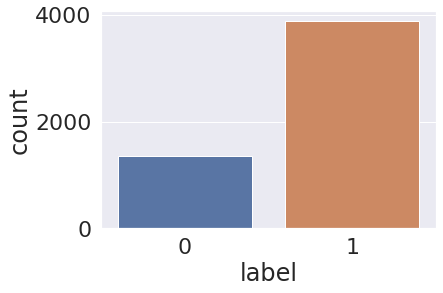

In [12]:
sns.countplot(x='label', data=df_train)

In [13]:
from sklearn.utils import class_weight
class_weights = list(zip(np.unique(df_train.label), class_weight.compute_class_weight('balanced',np.unique(df_train.label),df_train.label)))
from sklearn import preprocessing
a = np.array((class_weights))
a = preprocessing.normalize(a)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=0    0
1    0
2    0
3    0
4    0
    ..
3    1
4    1
5    1
6    1
7    1
Name: label, Length: 5232, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [14]:
## Apply Weighted Loss w.r.t Size of label
## So class with low number of images get higher weight
## while class with High number of images get lower weight

weight = torch.Tensor(a[1])
criterion = nn.NLLLoss(weight= weight).to(DEVICE)
# Show the Weights (should be close to this ==> [0.74, 0.25])
print(criterion.weight)

tensor([0.8293, 0.5587])


In [123]:
def train_fn(batches, model, optim, device=DEVICE):
    model.train() # set the model mode => training
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        # Get Your image and targets from the given batch
        imgs, labels = batch
        # Forward Propagation
        out = model(imgs)
        ## Get Your predictions from model
        labels_pred = out
        # Calculate Loss
        ## Get your loss bet. Predictions and Targets
        loss = criterion(out, labels)
        # Backward propagation (Check: https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944)
        loss.backward()
        ## - Zero your optimizer gradients
        optim.zero_grad()
        opti.step()
        ## - Calculate loss gradient
        
        ## - Make step with optimizer
        ## - Accumulating Loss & Accuracy Across batches
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

In [192]:
def train_fn(batches, model, optim, scheduler, device=DEVICE):
    model.train() # set the model mode => training
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        imgs, labels = batch['images'], batch['targets']
        optim.zero_grad()
        out = model(imgs)
        labels_pred = out
        loss = criterion(out, labels)
        loss.backward()
        optim.step()
        ## - Calculate loss gradient        
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    scheduler.step()
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

In [193]:
def eval_fn(batches, model, device=DEVICE):
    """
    Calculate the model accuracy & loss on given eval data ... no training is needed here
    just prediction and comparing results
    """
    ## Write your code here
    correct = 0
    total = 0
    ep_loss = 0
    with torch.no_grad():
        for batch in tqdm(batches, total=len(batches), position=0, leave=True):
            imgs, labels = batch['images'], batch['targets']
            out = model(imgs)
            loss = criterion(out, labels)
            ep_loss += loss.item()
            for idx, i in enumerate(out):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
                
    ep_acc = round(correct/total, 3)
    
    return ep_loss, ep_acc


In [194]:
def pred_fn(batches, model, device=DEVICE):
    """
    Predict Test batches
    Args:
        batches (generator): Test Batches
        model (model object): Trained Model
        device (gpu/cpu device, optional): active device. Defaults to DEVICE.

    Returns:
        predictions: List of predictions
        true_labels: List of true labels
    """
    ## Write your code here
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(batches, total=len(batches), position=0, leave=True):
                imgs, labels = batch['images'], batch['targets']
                out = model(imgs)
                _, predicted = torch.max(out.data, 1)
                predictions.append(predicted)
                true_labels.append(labels)
    
    return predictions, true_labels

In [161]:
class Dataset():

    def __init__(self, img_paths, targets, transform=None):
        ## Write your code here
        self.img_paths = img_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        ## Write your code here
        return len(self.img_paths)

    def __getitem__(self, idx):
        ## Write your code here
        target = self.targets[idx]
        image = Image.open(self.img_paths[idx])
        transformed = self.transform(image)
        image = transformed
        return {
            'images': image,
            'targets': torch.tensor(target)
            }

In [126]:
class XrayClassifier(nn.Module):
    def __init__(self, in_channels=1, out_channels=128, num_classes=2):
        super(XrayClassifier, self).__init__()
        # out_shape =  [ (n - k + 2*p) / s ] + 1
        # p: (default = 0) padding
        # s: (default = 1) stride
        # k: kernel
        # out_shape =  [n - k  + 1]
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(179776, 256)
        self.fc2 = nn.Linear(256, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim=1) # flattening out
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [127]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 1
BS = 1 # Batch Size
ex = torch.rand(BS, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
model = XrayClassifier()
model.eval()
out = model(ex)

print(out.shape) 
out

torch.Size([1, 2])


tensor([[-0.7303, -0.6573]], grad_fn=<LogSoftmaxBackward>)

In [197]:
# Train Test Split with your custome balanced method
val = df_train.groupby('label').apply(lambda x: x.sample(n=523)).reset_index(drop = True)
a = df_train.merge(df2, how='left', indicator=True)
a = a[a._merge != 'both']
del a['_merge']
train = a
train, val = train.reset_index(drop=True), val.reset_index(drop=True)
train_imgs, val_imgs, train_labels, val_labels = train.img_path, val.img_path, train.label, val.label
print(f"{len(train_imgs):,} Training imgs")
print(f"{len(val_imgs):,} Validation imgs")

4,186 Training imgs
1,046 Validation imgs


In [198]:
print(val['img_path'].duplicated().any())
val.label.value_counts(normalize=True)

False


0    0.5
1    0.5
Name: label, dtype: float64

In [199]:
test = df_test.reset_index(drop=True)
test_imgs, test_labels = test.img_path, test.label

In [200]:
train_dataset = Dataset(train_imgs, train_labels, TR)
val_dataset = Dataset(val_imgs, val_labels, TR)
test_dataset = Dataset(test_imgs, test_labels, TR)

In [201]:
train_batches = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_batches = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_batches = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [145]:
model = XrayClassifier()
## Write your code here # Note: Try with different optimizers and see how it affect the results...
optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)

In [146]:
## Create History For saving your losses and accuracies
history= {}
history['train_loss'] = []
history['val_loss'] = []
history['train_acc'] = []
history['val_acc'] = []

In [202]:
for epoch in range(EPOCHS):
        s = time()
        # train
        ep_train_loss, ep_train_acc = train_fn(train_batches, model, optim, scheduler)
        # eval
        ep_val_loss, ep_val_acc = eval_fn(val_batches, model)
        e = time()
        # test
        ep_test_loss, ep_test_acc = eval_fn(test_batches, model)

        epoch_t = remainig_time(e - s)
        whole_time = remainig_time((e - s) * (EPOCHS - epoch))
        print(f"\nEpoch:{epoch}/{EPOCHS}---Loss-train:{ep_train_loss:.4f}---Loss-Val: {ep_val_loss:.4f}---Acc-Train:{(ep_train_acc*100):.2f}%---Acc-Val: {(ep_val_acc*100):.2f}%---Acc-Test: {(ep_test_acc*100):.2f} ---%epoch elapsed:{epoch_t}---Remaining:{whole_time}")
        
        ## Write your code here ## append the training loss
        history['train_loss'].append(ep_train_loss)
        ## Write your code here ## append the validation loss
        history['val_loss'].append(ep_train_acc)
        ## Write your code here ## append the training acc
        history['train_acc'].append(ep_val_loss)
        ## Write your code here ## append the validation acc
        history['val_acc'].append(ep_val_acc)

        if ep_val_acc > MIN_ACC:
            print("Saving Model ...")
            model_name = f'Xray_ep_{epoch}_acc__.pth'
            MIN_ACC = ep_test_acc
            # Save Your model Checkpoint
            ## Write your code here
            save_model(model, optim, ep_train_loss, ep_val_loss, ep_train_acc, ep_val_acc, epoch, model_name, model_path='')

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]



Epoch:0/5---Loss-train:15.7075---Loss-Val: 3.8873---Acc-Train:95.68%---Acc-Val: 96.00%---Acc-Test: 75.30 ---%epoch elapsed:6 min---Remaining:33 min
Saving Model ...


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]



Epoch:1/5---Loss-train:11.4575---Loss-Val: 5.9158---Acc-Train:96.78%---Acc-Val: 94.70%---Acc-Test: 70.20 ---%epoch elapsed:6 min---Remaining:26 min
Saving Model ...


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



Epoch:2/5---Loss-train:8.9063---Loss-Val: 6.0768---Acc-Train:97.64%---Acc-Val: 94.20%---Acc-Test: 72.40 ---%epoch elapsed:7 min---Remaining:21 min
Saving Model ...


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]



Epoch:3/5---Loss-train:8.5596---Loss-Val: 3.4159---Acc-Train:97.76%---Acc-Val: 96.60%---Acc-Test: 74.50 ---%epoch elapsed:7 min---Remaining:14 min
Saving Model ...


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



Epoch:4/5---Loss-train:5.6894---Loss-Val: 2.0966---Acc-Train:98.47%---Acc-Val: 98.80%---Acc-Test: 74.40 ---%epoch elapsed:7 min---Remaining:7 min
Saving Model ...


In [218]:
MODEL_PATH = '' # Get your model path
checkpoint = load_model("model_CNN.pth")
model.load_state_dict(checkpoint['model_state_dict']) # Just loading the model weights

In [217]:
save_model(model, optim, ep_train_loss, ep_val_loss, ep_train_acc, ep_val_acc, epoch, "model_CNN.pth", model_path='')

In [204]:
preds, labels = pred_fn(test_batches, model)

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [251]:
print(f"Accuracy: {(np.array(torch.cat((preds))) == np.array(torch.cat((labels)))).mean()*100:.1f}% On Test Set")

Accuracy: 74.4% On Test Set


In [250]:
print(classification_report(torch.cat((preds)), torch.cat((labels)), target_names=CLASSES))

              precision    recall  f1-score   support

      NORMAL       0.32      0.99      0.48        76
   PNEUMONIA       1.00      0.71      0.83       548

    accuracy                           0.74       624
   macro avg       0.66      0.85      0.66       624
weighted avg       0.91      0.74      0.79       624



In [224]:
import pickle
model_name = 'CNN_model.pk'
pickle.dump(model, open(model_name, 'wb'))

In [254]:
cm = confusion_matrix(torch.cat((preds)), torch.cat((labels)))

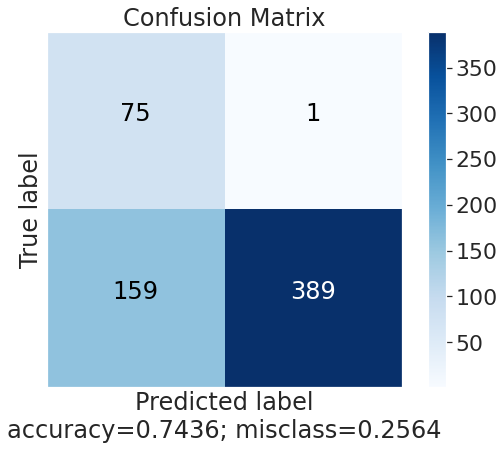

In [266]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [],
                      title        = "Confusion Matrix")